In [1]:
import coralme
import pandas
from coralme.solver.solver import ME_NLP
import cobra
import numpy
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
pandas.set_option('display.max_colwidth', None)

In [2]:
# From https://journals.asm.org/doi/10.1128/aem.01643-14
glucose_uptake = -2.21

### Load

In [3]:
model = cobra.io.load_json_model("./pputidame/inputs/m_model.json")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-03


In [4]:
me = coralme.io.pickle.load_pickle_me_model("./pputidame/MEModel-step3-pputida-Keff.pkl")

In [5]:
medium = pandas.read_csv("./media/M9.txt",index_col="ID",comment="#")["Bound"]
def enforce_medium(model,medium):
    for r in model.reactions.query("^EX_"):
        r.lower_bound = 0
    for r,lb in medium.items():
        model.reactions.get_by_id(r).lower_bound = lb

enforce_medium(model,medium)
assert model.optimize().objective_value > 1e-3
enforce_medium(me,medium)
assert me.optimize() == True

### M-model

In [95]:
model.reactions.EX_glc__D_e.bounds = (glucose_uptake,0)
sol1 = model.optimize().to_frame()["fluxes"]

In [98]:
sol1.to_csv("./datasets/metabolic-flux-analysis/m_model.csv")

### ME-model

In [9]:
me.reactions.EX_glc__D_e.bounds = (glucose_uptake,0)
me.optimize(max_mu=0.6)

Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	0.3000000000000000	Not feasible
        2	0.1500000000000000	Optimal
        3	0.2250000000000000	Not feasible
        4	0.1875000000000000	Not feasible
        5	0.1687500000000000	Optimal
        6	0.1781250000000000	Optimal
        7	0.1828125000000000	Optimal
        8	0.1851562500000000	Optimal
        9	0.1863281250000000	Not feasible
       10	0.1857421875000000	Optimal
       11	0.1860351562500000	Not feasible
       12	0.1858886718750000	Not feasible
       13	0.1858154296875000	Not feasible
       14	0.1857788085937500	Not feasible
       15	0.1857604980468750	Optimal
       16	0.1857696533203125	Not feasible
       17	0.1857650756835937	Not feasible
       18	0.1857627868652344	Not feasible
       19	0.1857616424560547	Optimal
       20	0.1857622146606445	Not feasible


True

In [23]:
sol2 = pandas.Series(me.get_metabolic_flux()).rename("fluxes")

Building reaction dictionary...                                            : 100.0%|██████████|  2563/ 2563 [00:00<00:00]
Processing ME-model Reactions...                                           : 100.0%|██████████| 14418/14418 [00:00<00:00]


In [14]:
sol2.to_csv("./datasets/metabolic-flux-analysis/me_model.csv")

### Comparison

In [38]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from scipy import stats
from scipy.stats import pearsonr

In [65]:
df = pandas.concat([sol1.rename("M"),sol2.rename("ME")],axis=1).dropna()

In [75]:
df = numpy.log10(df.abs()).dropna()

PearsonRResult(statistic=0.8076826884028974, pvalue=0.0) 0.6523513251457318


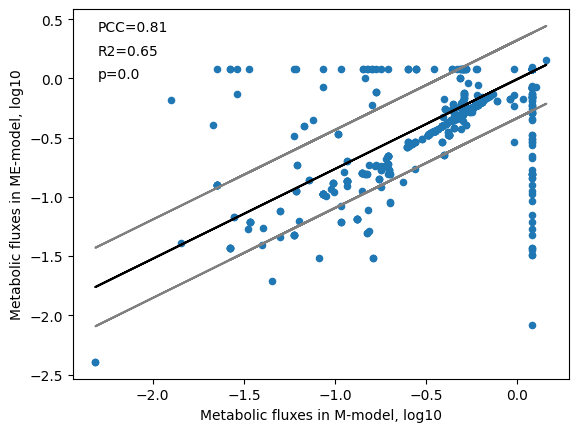

In [82]:
# colors = ["brown","blue","green"]
X = df["M"].values
y = df["ME"].values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
# print(est2.summary())
fig,ax = plt.subplots(1,1)
df.plot.scatter(x="M",y="ME",ax=ax)
plt.plot(X,est2.predict(),color="black")

res = pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1)))
print(res,res.statistic**2)


# Confidence interval
st, data, ss2 = summary_table(est2, alpha=0.05)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T
plt.plot(X, predict_ci_low, color="gray")
plt.plot(X, predict_ci_upp, color="gray")
plt.text(-2.3,0.4,f"PCC={round(res.statistic,2)}")
plt.text(-2.3,0.2,f"R2={round(res.statistic**2,2)}")
plt.text(-2.3,0.,f"p={round(res.pvalue,2)}")
# plt.plot([-15,15],[-15,15],linestyle='--',color="gray")
plt.xlabel("Metabolic fluxes in M-model, log10")
plt.ylabel("Metabolic fluxes in ME-model, log10")
plt.savefig("./figures/M-vs-ME-metabolic-fluxes.svg",format="svg")

### Save as HTML

In [115]:
import escher
from escher import Builder
import cobra
from time import sleep
escher.rc['never_ask_before_quit'] = True

In [116]:
builder = Builder(
    model_json='./pputidame/inputs/m_model.json',
    map_json="./datasets/metabolic-flux-analysis/e_coli_core.Core metabolism (23).json",
    reaction_data = sol1,
)
builder.save_html('datasets/metabolic-flux-analysis/m_model_map.html')

In [122]:
builder = Builder(
    model_json='./pputidame/inputs/m_model.json',
    map_json="./datasets/metabolic-flux-analysis/e_coli_core.Core metabolism (23).json",
    reaction_data = sol2,
)
builder.save_html('datasets/metabolic-flux-analysis/me_model_map.html')

### Save simulation conditions

In [8]:
def save_dict_of_dataframes_to_excel(dict_of_dataframes, excel_filename):
    """
    Save a dictionary of dataframes into an Excel worksheet, with each dataframe in a separate sheet.

    Parameters:
    - dict_of_dataframes (dict): A dictionary where keys are sheet names and values are dataframes.
    - excel_filename (str): The name of the Excel file to be created.

    Example:
    ```python
    dataframes_dict = {'Sheet1': df1, 'Sheet2': df2, 'Sheet3': df3}
    save_dict_of_dataframes_to_excel(dataframes_dict, 'output.xlsx')
    ```
    """
    with pandas.ExcelWriter(excel_filename, engine='xlsxwriter') as writer:
        for sheet_name, dataframe in dict_of_dataframes.items():
            dataframe.to_excel(writer, sheet_name=sheet_name, index=True)


In [9]:
dct = {
    "Constraints" : pandas.Series({r.id:r.lower_bound for r in model.reactions.query("^EX_") if r.lower_bound<0}),
    "ME-model simulations" : pandas.read_csv("./datasets/metabolic-flux-analysis/me_model.csv",index_col=0),
    "M-model simulations" : pandas.read_csv("./datasets/metabolic-flux-analysis/m_model.csv",index_col=0),
}

In [11]:
save_dict_of_dataframes_to_excel(dct,"./datasets/supplementary/SupplementaryTable1.xlsx")